In [1]:
from typing import TypedDict, List, Optional, Annotated, Sequence
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AIMessage
# Base or foundation class for all types of message types in LangGraph
from langchain_core.messages import BaseMessage
# Passes data back to LLM after calling a tool
from langchain_core.messages import ToolMessage
# Message for providing instructions to LLM
from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
load_dotenv()

False

In [2]:
# This is a global variable to store the document content
document_content = ""

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

@tool
def update(content: str) -> str:
    """ Updates the document with the provided content. """
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"

@tool
def save(filename: str) -> str:
    """ Save the current document to a text file and finish the process.
    
    Args:
        filename: Name of the text file.
    """

    global document_content

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"
    
    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        print(f"Document has been saved to {filename}")
        return f"Document has been saved successfully to {filename}."
    except Exception as e:
        return f"Error saving document: {str(e)}"

tools = [update, save]
model = ChatOpenAI(model='gpt-4o').bind_tools(tools=tools)

In [3]:
def our_agent(state: AgentState) -> AgentState:
    """ This agent updates and saves the current document """

    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
                                  
    The current document content is:{document_content}
    """)

    if not state['messages']:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)
    else:
        user_input = input("What would you like to do with the document?")
        print(f"USER: {user_input}")
        user_message = HumanMessage(content=user_input)
    
    all_messages = [system_prompt] + list(state['messages']) + [user_message]

    response = model.invoke(all_messages)

    print(f"AI: {response.content}")
    print(f"Using Tools: {response.tool_calls}")

    return {
        'messages': list(state['messages']) + [user_message, response]
    }

def router(state: AgentState) -> str:
    """ Determines if we should continue to end the conversation."""

    messages = state['messages']

    if not messages:
        return "continue"
    
    # This looks for the most recent tool message
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if isinstance(message, ToolMessage) and "saved" in message.content.lower() and "document" in message.content.lower():
            return "end"
    return "continue"

def print_messages(messages):
    if not messages:
        return
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"Tool Result: {message.content}")
            

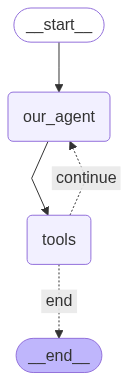

In [4]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", our_agent)
graph.add_node("tools", ToolNode(tools=tools))

graph.add_edge(START, "our_agent")
graph.add_edge("our_agent", "tools")

graph.add_conditional_edges(
    source="tools",
    path=router,
    path_map={
        "continue": "our_agent",
        "end": END
    }
)
agent = graph.compile()
agent

In [5]:
def run_document_agent():
    print("\n ===== Drafter =====")
    
    state = {"messages": []}
    for step in agent.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step['messages'])
    print("\n Drafter Finished")

if __name__ == "__main__":
    run_document_agent()


 ===== Drafter =====
AI: We currently don't have any content in the document. Please provide the information or content you would like to add or update, and I will assist you with that.
Using Tools: []
USER: 
AI: Please let me know what content you would like to add or modify in the document, and I will help you with the necessary updates.
Using Tools: []
USER: Create an email to Tom saying I cannot make it to the meeting today
AI: 
Using Tools: [{'name': 'update', 'args': {'content': 'Subject: Unable to Attend Meeting Today\n\nHi Tom,\n\nI hope this message finds you well. I am writing to let you know that I am unable to attend the meeting scheduled for today. I apologize for any inconvenience this may cause.\n\nPlease let me know if there are any updates or decisions made during the meeting that I should be aware of. I will make sure to catch up on everything at the earliest possible opportunity.\n\nThank you for your understanding.\n\nBest regards,\n\n[Your Name]'}, 'id': 'call_Hj4